#  Sur-apprentissage, régularisation et dropout

## Sur-apprentissage

on se place dans le cadre des modèles paramétriques:
- approximation linéaire,
- approximation polynomiale,
- réseaux de neurones,...

 et d'un problème des moindre carrés. On veut donc, à partir d'échantillons $(x_i,y_i)$ avec $1\leq i\leq n$ trouver une approximation de $y=f(x)$ tel que on minimise
 $$
 \operatorname{min} \sum_{i=1}^n \parallel y_i - f_{\theta}(x_i)\parallel_2^2
 $$
 
 avec $f_{\theta}$ le modèle paramétrique. On part du principe qu'on a souvent des données bruitées, donc du type
 $$
 y_i = f(x_i) + \epsilon_i
 $$
avec $\epsilon_i$ une perturbation Gaussienne.

Ce type problème est une **régression**. A la différence de l'interpolation on ne demande pas au modèle de passer obligatoirement par les exemples.

**Surapprentissage**: C'est lorsque le modèle approche trop bien l'échantillon et que cela à pour conséquence de dégrader son efficacité sur des données qui ne sont pas dans l'échantillon. 

On risque d'apprendre le bruit ou les biais de l'échantillon.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def true_fun(X):
    return  np.cos(1.0 * np.pi * X)

np.random.seed(0)

def plot_overfitting(n_samples):
    degrees = [1, 2, 5, 20]

    X = np.random.uniform(-1.0,1.0,n_samples)
    y = true_fun(X) + np.random.randn(n_samples) * 0.1

    plt.figure(figsize=(15, 2.5))
    for i in range(len(degrees)):
        ax = plt.subplot(1, len(degrees), i + 1)

        polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
        linear_regression = LinearRegression()
        pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
        pipeline.fit(X[:, np.newaxis], y)

        X_test = np.linspace(-1.0, 1.0, 100)
        plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
        plt.plot(X_test, true_fun(X_test), label="True function")
        plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
        plt.xlim((-1.1, 1.1))
        plt.ylim((-2.0, 2.0))
    plt.show()

**Exemple**: régression polynomiale avec (200 puis 30 points) sur la fonction $cos(\pi x)$.

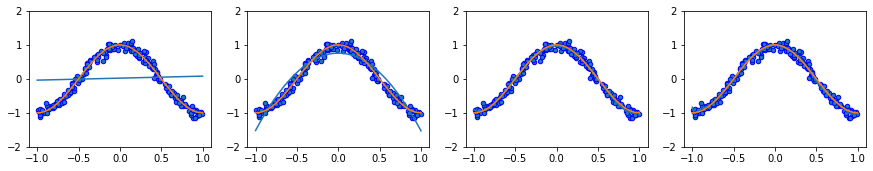

In [17]:
plot_overfitting(200)

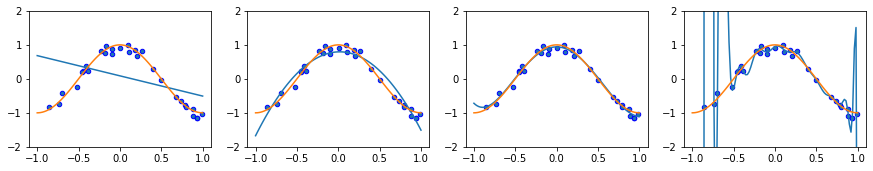

In [18]:
plot_overfitting(30)

**But**: 
- Montrer sur la régression linéaire notamment, pourquoi cela arrive et comment éviter le problème.
- montrer l'importance de ce problème et les solutions sur des réseaux de neurones.

## Régression linéaire 

On a un problème qui peut s'écrire par:

$$
Y_i = (\mathbf{\beta},\mathbf{X}_i)+\alpha_0 + \epsilon
$$

avec $\mathbf{X}\in \mathbb{R}^m$ et $Y\in \mathbb{R}$.

avec $\epsilon = \mathcal{N}(0,\sigma)$ un bruit Gaussien. On connait un échantillon $(\mathbf{X}_1,...,\mathbf{X}_n)$ et $(Y_1,...,Y_n)$ bruité du modèle.

Le problème de régression consiste à trouver $(\mathbf{\beta},\alpha)$ à partir de l'échantillon.

On écrit la matrice $\mathcal{X} \in \mathcal{M}_{n,m+1}
(\mathbb{R})$ tel que

$$
\mathcal{X}_{i1}=1, \quad \mathcal{X}_{ij}= X_j^i
$$

et le vecteur $\mathcal{Y} \in \mathcal{M}_{n}(\mathbb{R})$ tel que

$$
 \mathcal{Y}_{i}= Y^i
$$

On pose $\hat{\beta}=(\beta,\alpha)$. On cherche la solution du problème:

$$
\hat{\beta}^*=\operatorname{argmin}_{\hat{\beta}} E(\hat{\beta})=\operatorname{argmin}_{\hat{\beta}}\parallel \mathcal{Y}-\mathcal{X}\hat{\beta}\parallel_2
$$

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
import numpy.random as rand
import matplotlib.pyplot as plt
from IPython.display import Image

In [3]:
def generate_data(sigma,beta,alpha,n,m): ## génère n exemple dans R^m avec le modèle $f$
    X = np.zeros((n,m)) ## creation de la matrice à n exemple de dimension m
    Y = np.zeros(n) ## creation de la matrice à n exemple de dimension l
    Xhat = np.zeros((n,m)) ## creation de la matrice à n exemple de dimension m
    Yhat = np.zeros(n)
    eps = rand.normal(0.0,sigma,n) ## vecteur des bruits
    meanY = 0.0
    meanX = np.zeros(m)
    varianceX = np.zeros(m)
    for i in range(0, n):
        X[i,:]=rand.uniform(0.0,2.0,m) # m nombre aléatoire entre 0 et 1
        Y[i]= np.dot(beta,X[i,:])+alpha+eps[i]
        meanX[:] = meanX + X[i,:]/n
        meanY = meanY + Y[i]/n 
        varianceX[:] = varianceX[:] + X[i,:]*X[i,:]/n
        
    for i in range(0, n):
        Xhat[i,:]= (X[i,:]-meanX[:])/(varianceX[:])
        Yhat[i]= (Y[i]-meanY)
    
    return X,Y,eps

In [4]:
# calcul les erreur pour la regression Rdige
def errorR(lam,beta_hat,alpha_hat,X,Y,n,m):
    if lam >0:
        reg = Ridge(alpha=lam,tol=10-10).fit(X,Y)
    else: 
        reg = LinearRegression().fit(X, Y)
     
    Yref = np.zeros(n); Ycom = np.zeros(n)   
    Ynewref = np.zeros(50); Ynewcom = np.zeros(50)
       
    Xnew = np.zeros((50,m)) # entrées et sortiesde l'échantillon de test
    for i in range(0, 50):
        Xnew[i,:]=rand.uniform(0.0,2.0,m)   
        Ynewref[i]= np.dot(beta_hat,Xnew[i,:])+alpha_hat
        Ynewcom[i] = np.dot(reg.coef_,Xnew[i,:])+reg.intercept_

    for i in range(0, n): # sortie de l'échantillon d'entrainement
        Ycom[i] = np.dot(reg.coef_,X[i,:])+reg.intercept_
        Yref[i]= np.dot(beta_hat,X[i,:])+alpha_hat

    Error=0.0;  ErrorQuad=0.0
    Biais=0.0; Var=0.0;  normp=0.0

    Error = np.mean((Ynewref - Ynewcom)**2)
    ErrorQuad = np.mean((Y - Ycom)**2) 
    Biais = np.mean(Yref-Ycom)
    Var= np.mean((Ycom-np.mean(Ycom))**2)

    normp = reg.intercept_**2
    for i in range(0,m):
        normp = normp+reg.coef_[i]**2
    normp/(m+1) 

    Biais *=Biais
    return Error,ErrorQuad,Biais,Var,normp

# compute the error for Lasso regression
def errorL(lam,ratio,beta_hat,alpha_hat,X,Y,n,m):
    if lam >0:
        reg = ElasticNet(alpha=lam,l1_ratio=ratio,tol=10-5).fit(X,Y)
    else: 
        reg = LinearRegression().fit(X, Y)
     
    Yref = np.zeros(n);  Ycom = np.zeros(n)   
    Ynewref = np.zeros(50); Ynewcom = np.zeros(50)
    
    Xnew = np.zeros((50,m)) # entrées et sortiesde l'échantillon de test
    for i in range(0, 50):
        Xnew[i,:]=rand.uniform(0.0,2.0,m)   
        Ynewref[i]= np.dot(beta_hat,Xnew[i,:])+alpha_hat
        Ynewcom[i] = np.dot(reg.coef_,Xnew[i,:])+reg.intercept_

    for i in range(0, n):  # sortie de l'échantillon d'entrainement
        Ycom[i] = np.dot(reg.coef_,X[i,:])+reg.intercept_
        Yref[i]= np.dot(beta_hat,X[i,:])+alpha_hat

    Error=0.0; ErrorQuad=0.0
    Biais=0.0; Var=0.0; normp=0.0

    Error = np.mean((Ynewref - Ynewcom)**2)
    ErrorQuad = np.mean((Y - Ycom)**2) 
    Biais = np.mean(Yref-Ycom)
    Var= np.mean((Ycom-np.mean(Ycom))**2)

    normp=0
    if abs(reg.intercept_)<0.000000001:
        normp = 1  
    for i in range(0,m):
        if abs(reg.coef_[i])<0.000000001:
            normp +=1
    normp = normp/(m+1)  

    Biais *=Biais
    return Error,ErrorQuad,Biais,Var,normp

### Cas de la petite dimension

Le minimum de la fonctionnelle $E(\hat{\beta})$ est atteint pour

$$
\nabla E(\hat{\beta}) =0 \Longleftrightarrow 2\mathcal{X}^t(\mathcal{X}\hat{\beta} - \mathcal{Y})=0
$$

donc

$$
\mathcal{X}^t\mathcal{X}\hat{\beta} = \mathcal{X}^t\mathcal{Y}
$$

avec $\mathcal{X}^t\mathcal{X} \in \mathcal{M}_{m+1,m+1}(\mathbb{R})$.

 On peut montrer que $Rg(\mathcal{X})=Rg(\mathcal{X}^t\mathcal{X})$. Dans ce cas la matrice est inversible si $Rg(\mathcal{X})=m+1$. 

On se place dans le cas $n>>m$. On a donc beaucoup d'exemples par rapport à la dimension du problème. 

Dans ce cas, on sera en général dans le cas inversible:

$$
\hat{\beta}^* = \underbrace{(\mathcal{X}^t\mathcal{X})^{-1}\mathcal{X}^t)}_{\mbox{pseudo inverse}}\mathbf{Y}
$$

On regarde l'erreur:

$$
\mathbb{E}\left[\left(\mathcal{Y}-\mathcal{X}\hat{\beta}^*\right)^2\right] = \sigma^2+ Biais[\hat{\beta}^*]^2 + Var[\hat{\beta}^*]
$$

avec 

$$
Biais[\hat{\beta}^*]=\left(\mathbb{E}\left[\mathcal{X}\hat{\beta}^*\right] - \mathbb{E}\left[\mathcal{X}\hat{\beta}_{ref}\right]\right)
$$

et 

$$
Var[\hat{\beta}^*]= \mathbb{E}\left[\left(\mathcal{X}\hat{\beta}^*-\mathbb{E}\left[\mathcal{X}\hat{\beta}^*\right]\right)^2\right]
$$

Ici $Biais[\hat{\beta}^*]=0$ et $Var[\hat{\beta}^*]=\sigma^2(\mathcal{X}^t\mathcal{X})^{-1}$.

L'estimateur obtenu est l'estimateur sans biais, linéaire en $\mathcal{Y}$ à la plus petite variance.

In [22]:
def plot_biais(): ## fonctionpour afficher l'image sur le dilemme biais variance.
    x = np.zeros((4,5)); y = np.zeros((4,5))
    theta = np.linspace(0.0,2.0*np.pi,200)
    c1x= 0.5+0.1*np.cos(theta); c1y= 0.5+0.1*np.sin(theta)
    c2x= 0.5+0.2*np.cos(theta); c2y= 0.5+0.2*np.sin(theta)
    c3x= 0.5+0.3*np.cos(theta); c3y= 0.5+0.3*np.sin(theta)
    c4x= 0.5+0.4*np.cos(theta); c4y= 0.5+0.4*np.sin(theta)
    x[0,:]=[0.55,0.53,0.50,0.48,.492]; y[0,:]=[0.51,0.52,0.50,0.49,.472]
    x[1,:]=[0.65,0.56,0.50,0.40,.455]; y[1,:]=[0.54,0.62,0.51,0.45,.41]
    x[2,:]=[0.75,0.73,0.70,0.68,.692]; y[2,:]=[0.71,0.72,0.70,0.69,.672]
    x[3,:]=[0.85,0.76,0.70,0.60,.655]; y[3,:]=[0.74,0.82,0.71,0.65,.61]
    title=['sans biais petite variance','sans biais grande variance','avec biais petite variance']
    title.append('avec biais grande variance')

    fig, axs = plt.subplots(2,2, figsize=(12, 6), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for i in range(0,4):
        axs[i].plot(c1x,c1y, c='y')
        axs[i].plot(c2x,c2y, c='r')
        axs[i].plot(c3x,c3y, c='g')
        axs[i].plot(c4x,c4y, c='b')
        axs[i].scatter(x[i,:],y[i,:],c='r')
        axs[i].set_title(title[i])

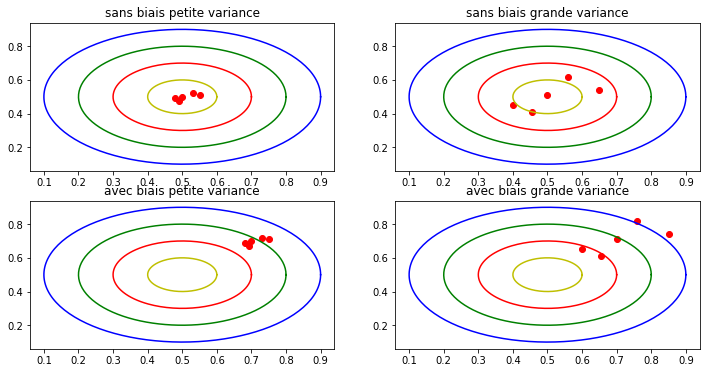

In [23]:
plot_biais()

In [24]:
def plot_result(lam,sigma,dim): ## affiche les erreurs pour une regréssion classique
    n = 100 
    EQ=[]; E=[]; B=[]; V=[]; iterl=[] ## liste de stockage
    for m in range(10,dim,5):
        beta= rand.uniform(-1.0,1.0,m)
        alpha = rand.uniform(-1.0,1.0)
        X,Y,eps= generate_data(sigma,beta,alpha,n,m)
        Error,ErrorQuad,Biais,Var,normp = errorR(lam,beta,alpha,X,Y,n,m)
        E.append(Error); EQ.append(ErrorQuad)
        B.append(Biais); V.append(Var); iterl.append(m)

    fig = plt.subplots(figsize=(16, 5))
    plt.subplots_adjust(hspace=0.5)
    ax0 = plt.subplot(2,2,1)
    ax0.plot(iterl,E)
    if dim>100:
        ax0.axvline(x=100, c='r')
    ax0.set_title("Erreur quadratique sur nouvelles données")
    ax1 = plt.subplot(2,2,2)
    ax1.plot(iterl,EQ)
    if dim>100:
        ax1.axvline(x=100, c='r')
    ax1.set_title("Erreur quadratique sur données bruitées")
    ax2 = plt.subplot(2,2,3)
    ax2.plot(iterl,B)
    ax2.set_title("Biais")
    ax3 = plt.subplot(2,2,4)  
    ax3.plot(iterl,V)
    ax3.set_title("Variance ")

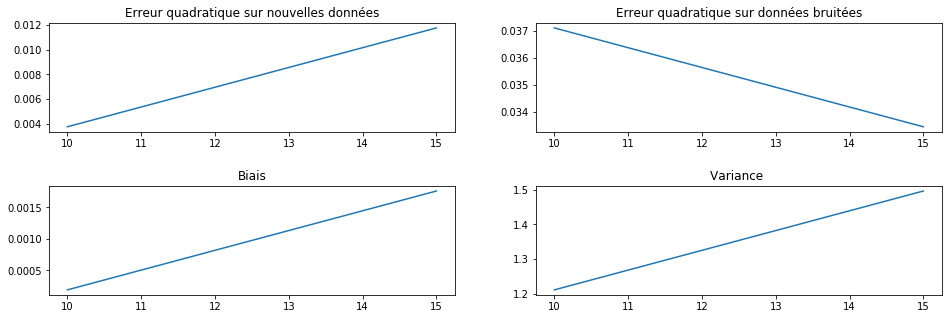

In [25]:
sigma=0.2
lam=0.0
plot_result(lam,sigma,20)

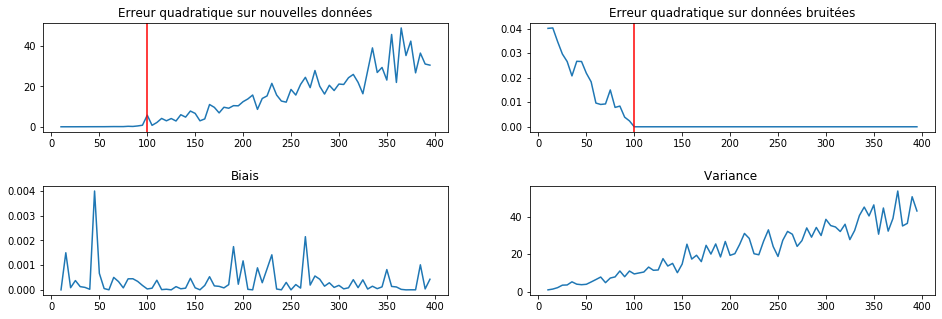

In [26]:
sigma=0.2
lam=0.0
plot_result(lam,sigma,400)

### Cas de la grande dimension

On voit que lorsque $m>n$ (nombre d'exemples inférieur à la dimension) on risque **Le sur-apprentissage**.

Le modèle colle **parfaitement aux données bruitées** mais moins bien avec les **données non bruitées** (le vrai modèle sous-jacent).

On le retrouve à travers la **variance** qui modélise la dispersion à la moyenne. Plus elle est grande plus le modèle est sensible au fluctuation d'échantillonnage.

**Explication**:

Si $m>n$ la matrice $(\mathcal{X}^t\mathcal{X})$ n'est pas **inversible**. Il existe plusieurs solutions (méthodes de gradients). 

Plus $m>>n$ plus la variance de **l'estimateur augmente** plus on va avoir du sur-apprentissage.

**Exemple**: Classification/régression sur des images. $m=10^6$ et souvent $n \approx 10^4- 10^7$.


## Régression avec régularisation $L^2$

**Idée**: Accepter une augmentation du biais (on espère petite) pour diminuer la variance. Pour cela on impose des contraintes supplémentaires.

**Régularisation Ridge**: on va ajouter une contrainte pour obtenir des poids pas trop larges.

On pose $\hat{\beta}=(\beta,\alpha)$. On cherche la solution du problème:

$$
\hat{\beta}^*=\operatorname{argmin}_{\hat{\beta}} E(\hat{\beta})=\operatorname{argmin}_{\hat{\beta}}\frac12\parallel \mathcal{Y}-\mathcal{X}\hat{\beta}\parallel_2^2
$$

sous contrainte $\sum_{i=1}^{m+1}\beta_i^2 \leq \tau$.

En général on résout une version rélaxée (contrainte faible):

$$
\hat{\beta}^*=\operatorname{argmin}_{\hat{\beta}} E(\hat{\beta})=\operatorname{argmin}_{\hat{\beta}}\frac12\parallel \mathcal{Y}-\mathcal{X}\hat{\beta}\parallel_2^2 + \lambda \sum_{i=1}^{m+1}\hat{\beta}_i^2
$$

On voit que plus $\lambda$ est grand plus on va chercher à minimiser la norme des poids. $\lambda=0$ donne le cas sans régularisation.

Le minimum de la fonctionnelle $E(\hat{\beta})$ est atteint pour

$$
\nabla E(\hat{\beta}) =0 \Longleftrightarrow 2\mathcal{X}^t(\mathcal{X}\hat{\beta} - \mathcal{Y}) + 2\lambda\hat{\beta}=0
$$

donc

$$
\left(\mathcal{X}^t\mathcal{X}+\lambda I_d\right)\hat{\beta} = \mathcal{X}^t\mathcal{Y}
$$

avec $\mathcal{X}^t\mathcal{X} \in \mathcal{M}_{m+1,m+1}(\mathbb{R})$. On voit que la régularisation ajoute une matrice homogène à l'idendité. La matrice $\mathcal{X}^t\mathcal{X}$ étant positive, on obtient un **problème inversible**.

$$
\hat{\beta}^* = \left(\mathcal{X}^t\mathcal{X}+\lambda I_d\right)^{-1}\mathcal{X}^t\mathcal{Y}
$$

On voit que pour $\lambda >>1$ on voit que $\nabla E(\hat{\beta}) =0$ équivaut à
$$
\hat{\beta} = O\left(\frac{1}{\lambda}\right)
$$

Donc la régularisation pousse bien les poids à être le plus petit possible.

On regarde l'erreur:

$$
\mathbb{E}\left[\left(\mathcal{Y}-\mathcal{X}\hat{\beta}^*\right)^2\right] = \sigma^2+ Biais[\hat{\beta}^*]^2 + Var[\hat{\beta}^*]
$$

avec 

$$
Biais[\hat{\beta}^*]=\left[\left(\mathcal{X}^t\mathcal{X}+\lambda I_d\right)^{-1}- (\mathcal{X}^t\mathcal{X})^{-1}\right](\mathcal{X}^t\mathcal{X})\hat{\beta}
$$

et 

$$
Var[\hat{\beta}^*]= \sigma^2\left[\left(\mathcal{X}^t\mathcal{X}+\lambda I_d\right)^{-1}(\mathcal{X}^t\mathcal{X})\left(\mathcal{X}^t\mathcal{X}+\lambda I_d\right)^{-1}\right]
$$
Il est possible de démontrer que le maximum de cette variance est atteint en $\lambda=0$.

In [7]:
def running_mean(x, N): ## Moyenne glissante
    out = np.zeros_like(x, dtype=np.float64)
    dim_len = len(x)
    for i in range(dim_len):
        if N%2 == 0:
            a, b = i - (N-1)//2, i + (N-1)//2 + 2
        else:
            a, b = i - (N-1)//2, i + (N-1)//2 + 1
        #cap indices to min and max indices
        a = max(0, a)
        b = min(dim_len, b)
        out[i] = np.mean(x[a:b])
    return out

In [326]:
def plot_reg_m(sigma,m): ### plot pour la régression Ridge
    fig = plt.subplots(figsize=(14, 7))
    plt.subplots_adjust(hspace=0.5)
    lamd_list = np.linspace(0.0,100,400)
    beta= np.linspace(-1.0,1.0,m) ### on se fixe une fonction particulière f(x)=\beta x+\alpha
    alpha = -2.0
    n = 100 
    E=[]; B=[]; V=[]; N=[]
    X,Y,eps= generate_data(sigma,beta,alpha,n,m)
    for il in range(0,len(lamd_list)):
        Error,ErrorQuad,Biais,Var,normp = errorR(lamd_list[il],beta,alpha,X,Y,n,m)
        E.append(Error); B.append(Biais)
        V.append(Var); N.append(normp)
        
    ax0 = plt.subplot(2,2,1)
    ax0.plot(lamd_list,E,c='b')
    ax0.plot(lamd_list,E[0]*np.ones(len(lamd_list)),c='r')
    ax0.plot(lamd_list,running_mean(E,10),c='y')
    ax0.set_title("Erreur quadratique nouvelles données")

    ax1 = plt.subplot(2,2,2)
    ax1.plot(lamd_list,B)
    ax1.plot(lamd_list,running_mean(B,10),c='y')
    ax1.set_title("Biais")

    ax2 = plt.subplot(2,2,3)
    ax2.plot(lamd_list,V,10)
    ax2.set_title("Variance")
    ax3 = plt.subplot(2,2, 4)
    ax3.plot(lamd_list,N)
    ax3.set_title("Norm Poids")

**Résultats**: On fixe m =20 et n=100 et on fait varier le coefficient de la Régularisation "Ridge"

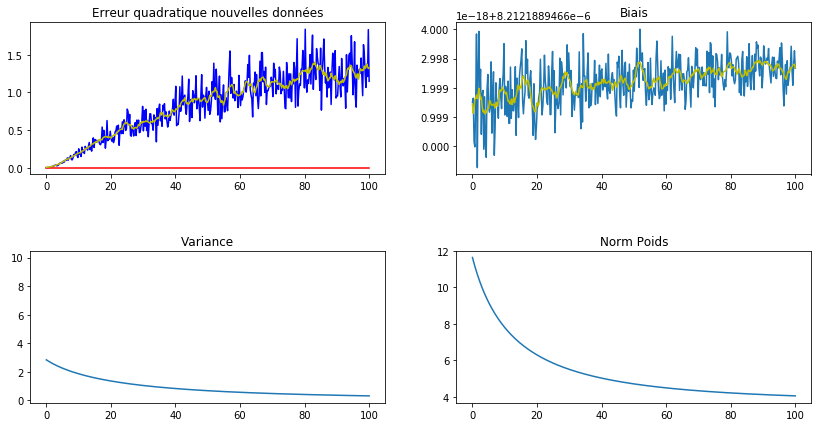

In [29]:
plot_reg_m(0.05,20)

**Résultats**: On fixe m =300 et n=100 et on fait varier le coefficient de la Régularisation "Ridge"

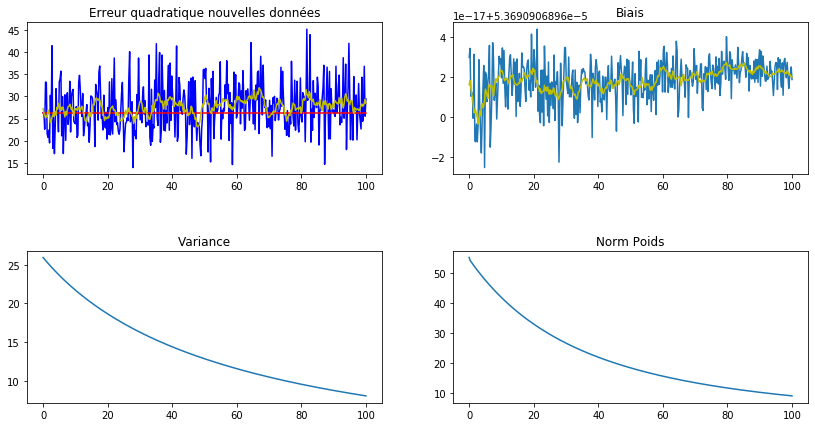

In [30]:
plot_reg_m(0.05,300)

## Regréssion avec régularisation $L^1$

La régularisation $L^2$ permet d'avoir "peu" de cofficients de $\beta$ grands. Une autre solution est de forcer à avoir peu de coefficients non nuls (on parle de **parcimonie**).

Pour cela on fait une régularisation $L^1$ appelée **régression Lasso**.

En général on résout sous forme faible:

$$
\hat{\beta}^*=\operatorname{argmin}_{\hat{\beta}}\frac12\parallel \mathcal{Y}-\mathcal{X}\hat{\beta}\parallel_2^2 + \lambda \sum_{i=1}^{m+1}\mid\hat{\beta}_i\mid
$$

Il existe de pas de solution analytique contrairement à la **régression Ridge**.

 Pour se convaincre de l'effet de la régularisation Lasso: cas simple $\mathcal{X}^t\mathcal{X}=I_d$.

 On développe $ \frac12\parallel\mathcal{Y}-\mathcal{X}\hat{\beta}\parallel_2$ ce qui donne

 $$
\frac12\parallel\mathcal{Y}-\mathcal{X}\hat{\beta}\parallel_2 = \frac{1}{2}(\mathcal{Y},\mathcal{Y})-(\mathcal{Y},\mathcal{X}\hat{\beta})+(\hat{\beta}, \mathcal{X}^t\mathcal{X}\hat{\beta}) = \frac{1}{2}(\mathcal{Y},\mathcal{Y})-(\mathcal{Y},\mathcal{X}\hat{\beta})+(\hat{\beta},\hat{\beta})
 $$

 puisque $\mathcal{Y}$ ne depend pas de $\hat{\beta}$, le problème de minimisation Lasso revient à minimiser

 $$
\operatorname{argmin}_{\hat{\beta}} -(\mathcal{Y},\mathcal{X}\hat{\beta})+(\hat{\beta},\hat{\beta}) + \lambda \sum_{i=1}^{m+1}\mid\hat{\beta}_i\mid
 $$

 On pose $\hat{\beta}_{mc}$ la solution du problème des moindres carrés sans régularisation:

 $$
\hat{\beta}_{mc}= (\mathcal{X}^t\mathcal{X})^{-1}\mathcal{X}^t\mathcal{Y}=\mathcal{X}^t\mathcal{Y}
 $$

 Le problème de minimisation se réécrit donc

 $$
\operatorname{argmin}_{\hat{\beta}} -(\hat{\beta}_{mc},\hat{\beta})+(\hat{\beta},\hat{\beta}) + \lambda \sum_{i=1}^{m+1}\mid\hat{\beta}_i\mid
 $$



On remarque que si $\hat{\beta}_{j,mc}>0$ alors $\hat{\beta}_{j}\geq 0$ et si $\hat{\beta}_{j,mc}<0$ alors $\hat{\beta}_{j}\leq 0$

La fonction étant pas dérivable en zéro on sépare les cas:
- $\hat{\beta}_{j,mc}>0$ 
dans ce cas la fonction minimisée est

$$
f(\hat{\beta}_j)= -\hat{\beta}_{j,nc}\hat{\beta}_j+\frac12\hat{\beta}_j^2+\lambda \hat{\beta}_j
$$

donc $f^{'}(\hat{\beta}_j)$ implique

$$
\hat{\beta}_j= \hat{\beta}_{j,mc}-\lambda
$$

Comme $\hat{\beta}_j \geq 0$ on a $\hat{\beta}_j= max(0,\hat{\beta}_{j,mc}-\lambda)$. Par le même raisonnement on obtient que pour $\hat{\beta}_{j,mc}<0$ on a 

$$
\hat{\beta}_j= max(0,-\hat{\beta}_{j,mc}-\lambda)
$$

donc à la fin

$$
\hat{\beta}_j = sign(\hat{\beta}_{j,mc})max(0,\mid\hat{\beta}_{j,mc}\mid-\lambda)
$$

On voit donc que plus $\lambda$ est large plus le nombre de coefficients nuls sera important.

La **régression Lasso** est très utile si un nombre faible de variables expliquent les données (hypothèse de parcimonie). 

Si le vrai vecteur solution est creux. La régression Lasso peut capter cette solution.

In [327]:
def plot_reg_ml(sigma,m): ### Affichage pour la régression Lasso
    fig = plt.subplots(figsize=(14, 7))
    plt.subplots_adjust(hspace=0.5)
    lamd_list = np.linspace(0.0,2,200)  ## liste des paramètres de régularisation
    beta= np.linspace(-1.0,1.0,m); alpha = -2.0 ## on crée un modèle particulier
    n = 100 
    E=[]; B=[]; V=[]; N=[]   # création des listes
    X,Y,eps= generate_data(sigma,beta,alpha,n,m)  # génération des données
    for il in range(0,len(lamd_list)):
        ### calcul des erreurs pour lambda_il
        Error,ErrorQuad,Biais,Var,normp = errorL(lamd_list[il],1.0,beta,alpha,X,Y,n,m) 
        E.append(Error); B.append(Biais)
        V.append(Var); N.append(normp)

    ax0 = plt.subplot(2,2,1)
    ax0.plot(lamd_list,E,c='b')
    ax0.plot(lamd_list,E[0]*np.ones(len(lamd_list)),c='r')
    ax0.plot(lamd_list,running_mean(E,10),c='y')
    ax0.set_title("Erreur quadratique nouvelles données")
    ax1 = plt.subplot(2,2,2)
    ax1.plot(lamd_list,B)
    ax1.plot(lamd_list,running_mean(B,10),c='y')
    ax1.set_title("Biais")
    ax2 = plt.subplot(2,2,3)
    ax2.plot(lamd_list,V)
    ax2.set_title("Variance")
    ax3 = plt.subplot(2,2, 4)
    ax3.plot(lamd_list,N)
    ax3.set_title("nb Poids nul")

**Résultats**: On fixe m =20 et n=100 et on fait varier le coefficient de la pénalisation "Lasso"


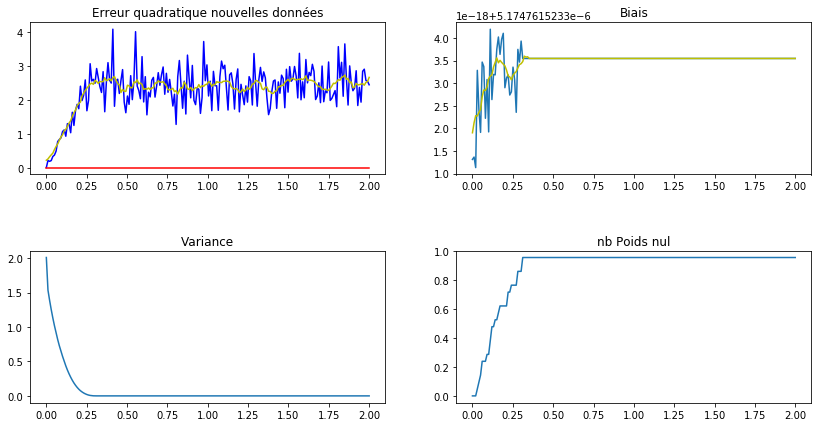

In [44]:
plot_reg_ml(0.05,20)

**Résultats**: On fixe m =300 et n=100 et on fait varier le coefficient de la pénalisation "Lasso"


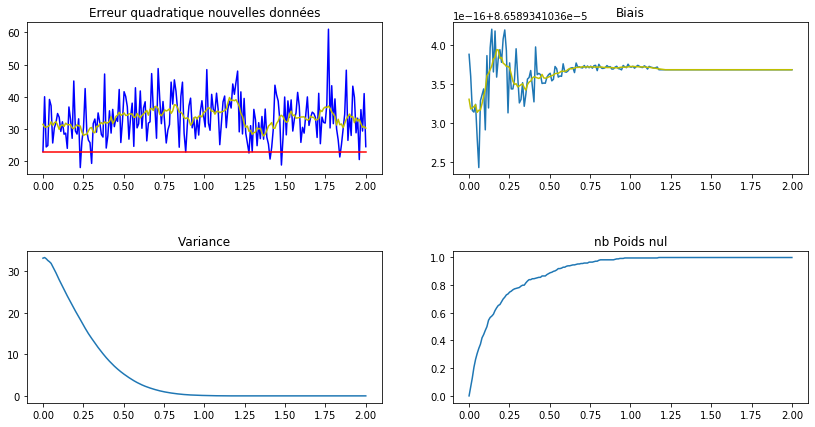

In [45]:
plot_reg_ml(0.05,300)

## Regréssion avec régularisation $L^1/L^2$

On peut évidemment mélanger les deux approches. On parle de **régression ElasticNet**.
En général on résout sous forme faible:

$$
\hat{\beta}^*=\operatorname{argmin}_{\hat{\beta}}\parallel \mathcal{Y}-(\hat{\beta},\mathcal{X})\parallel_2 + \lambda r \sum_{i=1}^{m+1}\mid\hat{\beta}_i\mid + \lambda (1-r) \sum_{i=1}^{m+1}\mid\hat{\beta}_i^2\mid
$$

Il existe de pas de solution analytique.

<img src="compare_reg.png" alt="Drawing" style="width: 500px;"/>

In [5]:
def plot_reg_me(sigma,lamb,m):  ## affichage pour la régression elasticnet
    fig = plt.subplots(figsize=(14, 7))
    plt.subplots_adjust(hspace=0.5)
    ratio = np.linspace(0.0,1,200) ## liste des valeur possible de r
    beta= np.linspace(-1.0,1.0,m); alpha = -2.0 ## on crée un modèle particulier
    n = 100 
    E=[]; B=[]; V=[]; N=[]  ## on crée les liste des erreurs
    X,Y,eps= generate_data(sigma,beta,alpha,n,m) # on génère les données
    for il in range(0,len(ratio)):
        #on cacul le ratio pour les données r_il
        Error,ErrorQuad,Biais,Var,normp = errorL(lamb,ratio[il],beta,alpha,X,Y,n,m)
        E.append(Error); B.append(Biais)
        V.append(Var); N.append(normp)

    ax0 = plt.subplot(2,2,1)
    ax0.plot(ratio,E,c='b')
    ax0.plot(ratio,E[0]*np.ones(len(ratio)),c='r')
    ax0.plot(ratio,running_mean(E,10),c='y')
    ax0.set_title("Erreur quadratique nouvelles données")

    ax1 = plt.subplot(2,2,2)
    ax1.plot(ratio,B)
    ax1.plot(ratio,running_mean(B,10),c='y')
    ax1.set_title("Biais")
    ax2 = plt.subplot(2,2,3)
    ax2.plot(ratio,V,10)
    ax2.set_title("Variance")
    ax3 = plt.subplot(2,2, 4)
    ax3.plot(ratio,N)
    ax3.set_title("nb Poids nul")

**Résultats**: On fixe m =20, n=100 et $\lambda=0.2$ et on fait varier le ratio entre les deux pénalisations de "Elastic Net"


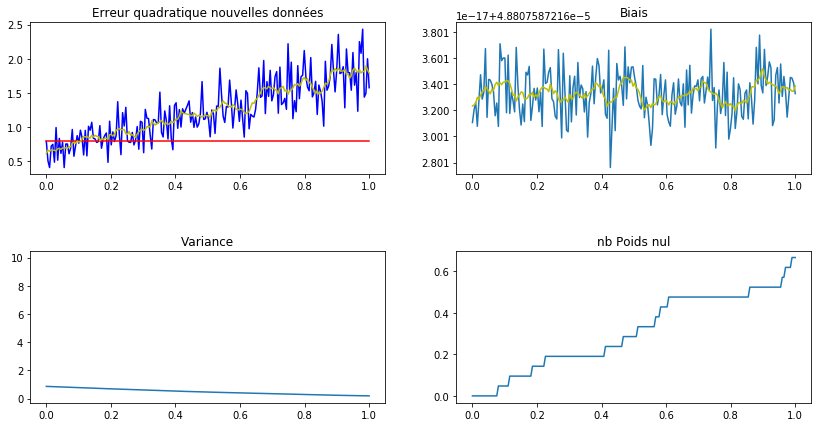

In [10]:
plot_reg_me(0.05,0.2,20)

**Résultats**: On fixe m =300, n=100 et $\lambda=0.2$ et on fait varier le ratio entre les deux pénalisations de "Elastic Net"

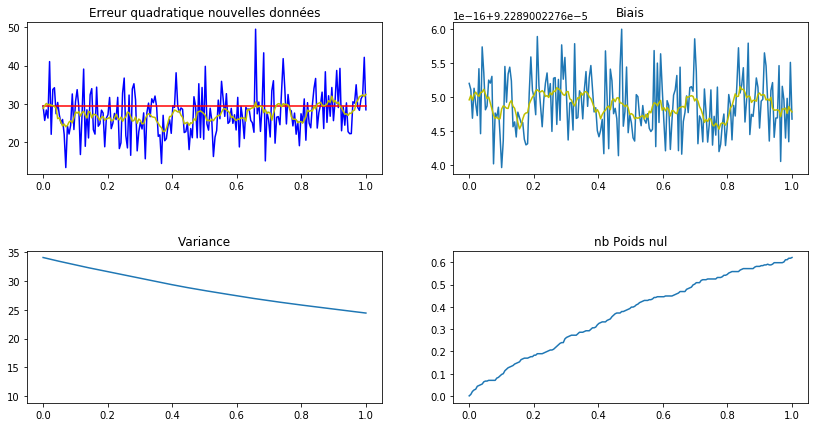

In [12]:
plot_reg_me(0.05,0.2,300)

## Dropout

On se place dans un cadre non régularisé. On résout le problème de régression par des méthodes itératives comme des **méthodes de gradients**.

**Idée de régularisation**: la meilleure façon de "régulariser" un modèle de taille fixe est de faire une moyenne pondérée des prédictions de tous les jeux de paramètre $\theta$ possible. Possible pour des petits modèles. Impossible pour des gros modèles comme les réseaux de neurones.

**But**: approcher cette moyenne sur des gros modèles (croissances exponentielle des jeux de paramètres possibles).

**Dropout (abandon)**: l'idée d'abandonner, désactiver certains paramètres temporairement pendant les itérations du gradient. En changeant régulièrement les paramètres gelés, on retrouve à la fin un effet de moyenne.

Dans le cas de la régression:

- si on gèle $\alpha$ paramètres à chaque itération, c'est comme si on était sur un problème de dimension $\alpha m$. On peut donc se retrouver dans des cas ou $\alpha m < n$ et donc pas de sur-apprentissage.

- chaque paramètre à une probabilité $p$ (loi de bernoulli) d'être temporairement abandonné.

- Pour la régression il suffit de mettre à zéro une sortie pour l'abandonner.

 On définit $R$ une matrice tel que 
 
 $$
 R_{ij} = \mathcal{B}(p)
 $$
 
 avec $\mathcal{B}$ une loi de Bernouilli. La dropout s écrit donc
 
 $$
 R * \mathcal{X}
 $$
 avec $*$ le produit terme à terme et le problème de minimisation s'écrit:
 
 $$
\hat{\beta}^*=\operatorname{argmin}_{\hat{\beta}}\mathbb{E}_{R \approx \mathcal{B}(p)}[\parallel \mathcal{Y}-R*\mathcal{X}\hat{\beta}\parallel_2^2]
$$

On peut montrer que le précédent problème revient à:

$$
\hat{\beta}^*=\operatorname{argmin}_{\hat{\beta}}[\parallel \mathcal{Y}-p\mathcal{X}\hat{\beta}\parallel_2^2] +p(1-p)\parallel \Gamma\hat{\beta}\parallel_2^2
$$

avec $\Gamma = \sqrt{diag(\mathcal{X}\mathcal{X}^t)}$

**Conclusion**: la dropout revient a une méthode de régularition Ridge ou les **poids associés aux plus grosses entrées sont les plus régularisés**.

**Preuve**:

On part de la fonction coût:

$$
\parallel \mathcal{Y}- R*\mathcal{X}\hat{\beta} \parallel_2^2= (\mathcal{Y},\mathcal{Y})- 2(R*\mathcal{X}\hat{\beta},\mathcal{Y}) +(R*\mathcal{X}\hat{\beta},R*\mathcal{X}\hat{\beta})
$$

On prend l'espérance pour obtenir:

$$
 (\mathcal{Y},\mathcal{Y})- 2(\mathbb{E}[R*\mathcal{X}]\hat{\beta},\mathcal{Y}) +(\hat{\beta},\mathbb{E}[(R*\mathcal{X})^tR*\mathcal{X}]\hat{\beta})
$$

on commence par la première espérance:
$$
(\mathbb{E}[R*\mathcal{X}])_{ij}=\mathbb{E}_{R}[(R*\mathcal{X})_{ij}]= X_{ij}\mathbb{E}_{R}[R_{ij}]= p X_{ij}
$$



On va maintenant calculer la seconde:

$$
((R*\mathcal{X})^tR*\mathcal{X})_{ij}=\sum_{k=1}^n R_{ki}R_{jk}X_{ki}X_{kj}
$$

On en déduit (car les lois sont indépendantes) que:

$$
(\mathbb{E}[(R*\mathcal{X})^tR*\mathcal{X}])_{ij}= p^2 (\mathcal{X}^t\mathcal{X})_{ij}, \quad \forall i\neq j
$$

et 

$$
(\mathbb{E}[(R*\mathcal{X})^tR*\mathcal{X}])_{ij}= p (\mathcal{X}^t\mathcal{X})_{ii}, \quad \forall i= j
$$



Maintenant on revient au calcul global, on utilise la 1ère espérance pour avoir:

$$
\parallel \mathcal{Y}- R*\mathcal{X}\hat{\beta} \parallel_2^2 =\parallel \mathcal{Y}-p\mathcal{X}\hat{\beta}\parallel_2^2 -p^2(\mathcal{X}\hat{\beta} ,\mathcal{X}\hat{\beta} )+(\hat{\beta},\mathbb{E}[(R*\mathcal{X})^tR*\mathcal{X}]\hat{\beta})
$$

On obtient donc

$$
\parallel \mathcal{Y}- R*\mathcal{X}\hat{\beta} \parallel_2^2 =\parallel \mathcal{Y}-p\mathcal{X}\hat{\beta}\parallel_2^2+(\hat{\beta},(\mathbb{E}[(R*\mathcal{X})^tR*\mathcal{X}]-p^2(\mathcal{X}^t\mathcal{X}))\hat{\beta})
$$

En utilisant les calculs sur l'espérance $\mathbb{E}[(R*\mathcal{X})^tR*\mathcal{X}]$ on voit que

$$
(\mathbb{E}[(R*\mathcal{X})^tR*\mathcal{X}]-p^2(\mathcal{X}^t\mathcal{X}))=p(1-p)diag(\mathcal{X}^t\mathcal{X})
$$

ce qui permet de conclure.
**Fin preuve**

### Régularisation de Tikhonov

Il s'agit d'un cas généralisé de **Ridge** qu'on écrit sous la forme:


$$
\hat{\beta}^*=\operatorname{argmin}_{\hat{\beta}}[\parallel \mathcal{Y}-\mathcal{X}\hat{\beta}\parallel_2^2] +\parallel \Gamma\hat{\beta}\parallel_2^2
$$

avec $\Gamma$ une matrice. Le dropout comme la régularisation Ridge rentre dans ce cas.

**Exemple**: Lorsque les données sont issues d'une fonction continue sur une grille régulière. On peut utiliser dans ce cas une pénalisation de ce type:

$$
\int \mid\nabla f\mid^2 dP_x(x) = -\int f \Delta f dP_x(x)
$$

Plus la régularisaion est forte plus on irait vers des **approximations régulières** (simple) notamment vers les **zones ou la densité de point est forte**.

Ce genre de pénalisation peut être construite à partir des données (on ne détaillera pas).

# Régularisation et dropout pour les réseaux de neurones

On applique les réseaux de neurones régulièrement dans ces cas ou $m>n$ ou $m \approx n$ avec $m$ le nombre de paramètres. On est surtout très souvent dans des cas ou le nombre de paramètres > $n$. C'est ca qui provoque du **sur-apprentissage**.

La **régularisation est donc un outil très important**.

Le principe (modification de la fonction coût) reste le même pour les réseaux.

In [266]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow import keras

In [267]:
np.random.seed(10)

def generate_data2(sigma,n,m): ## génère n exemple dans R^m avec le modèle $f$
    X = np.zeros((n,m)) ## creation de la matrice à n exemple de dimension m
    Y = np.zeros(n) ## creation de la matrice à n exemple de dimension l
    Xhat = np.zeros((n,m)) ## creation de la matrice à n exemple de dimension m
    Yhat = np.zeros(n) ## creation de la matrice à n exemple de dimension l
    meanX = np.zeros(m)
    meanY = 0.0
    varianceX = np.zeros(m)
    
    eps = rand.normal(0.0,sigma,n) ## vecteur des bruits
    beta = np.random.uniform(-1.0,1.0,m)
    index = np.ones(m)
    index[0:5] = np.random.randint(1,4,5)
    beta[0] =2.0
    for i in range(0, n):
        X[i,:]=rand.uniform(0.0,2.0,m) # m nombre aléatoire entre 0 et 
        Y[i] = np.exp(X[i,0]*X[i,1])+ X[i,2]*X[i,5]*X[i,7]+1.5+eps[i]  
        for j in range(0, m):
            Y[i]=  Y[i] +beta[j]*(X[i,j]**index[j])
            
        meanX[:] = meanX + X[i,:]/n
        meanY = meanY + Y[i]/n 
        varianceX[:] = varianceX[:] + X[i,:]*X[i,:]/n
        
    for i in range(0, n):
        Xhat[i,:]= (X[i,:]-meanX[:])/(varianceX[:])
        Yhat[i]= (Y[i]-meanY)
    return X,Y

In [268]:
m = 20
n = 500
X_train,Y_train = generate_data2(0.015,n,m)

**Entrainement non-régularisé**

In [269]:
### définition des couches du réseau
premiere_couche = Dense(units=100, activation="relu", input_dim=20) 
couche_cachee1 = Dense(units=200, activation="relu")
couche_cachee2 = Dense(units=50, activation="relu")
couche_sortie = Dense(units=1, activation="linear")

model = Sequential() ### création du réseaux
model.add(premiere_couche) ### ajout de la première couche
model.add(couche_cachee1)
model.add(couche_cachee2)
model.add(couche_sortie)

In [270]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.98)
opt = keras.optimizers.Adam(learning_rate=lr_schedule) ## définition d'un optimisze

In [271]:
model.summary() ### affiche du résumé du modèle
model.compile(optimizer=opt, loss="mse", metrics=["mse"]) ## construction du modèle

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 100)               2100      
_________________________________________________________________
dense_102 (Dense)            (None, 200)               20200     
_________________________________________________________________
dense_103 (Dense)            (None, 50)                10050     
_________________________________________________________________
dense_104 (Dense)            (None, 1)                 51        
Total params: 32,401
Trainable params: 32,401
Non-trainable params: 0
_________________________________________________________________


In [272]:
def apply_ANN(X,Y):
    history= model.fit(X, Y, verbose=0, epochs=100, batch_size=40,validation_split=0.1)  ### apprentissage
    plt.plot(history.history['loss'])  ## historique de la fonction cout du jeu de donnée "train"
    plt.plot(history.history['val_loss']) ## historique de la fonction cout du jeu de donnée "test"
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return history

**Résultats dans le cas sans régularisation**

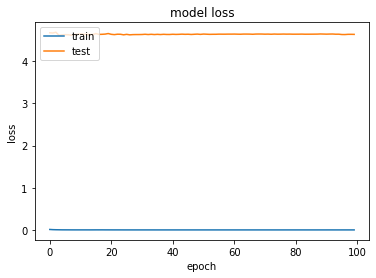

In [321]:
history=apply_ANN(X_train,Y_train)

**Entrainement avec régularisation Ridge**

In [276]:
premiere_couche2 = Dense(units=100, activation="relu",kernel_regularizer=keras.regularizers.l2(l=0.05), input_dim=20)
couche_cachee12 = Dense(units=200, activation="relu",kernel_regularizer=keras.regularizers.l2(l=0.05))
couche_cachee22 = Dense(units=50, activation="relu",kernel_regularizer=keras.regularizers.l2(l=0.025))
couche_sortie2 = Dense(units=1, activation="linear",kernel_regularizer=keras.regularizers.l2(l=0.025))

model2 = Sequential()
model2.add(premiere_couche2)
model2.add(couche_cachee12)
model2.add(couche_cachee22)
model2.add(couche_sortie2)

In [277]:
model2.summary()
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.98)
opt = keras.optimizers.Adam(learning_rate=lr_schedule) ## définition d'un optimisze
model2.compile(optimizer=opt, loss="mse", metrics=["mse"])

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 100)               2100      
_________________________________________________________________
dense_106 (Dense)            (None, 200)               20200     
_________________________________________________________________
dense_107 (Dense)            (None, 50)                10050     
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 51        
Total params: 32,401
Trainable params: 32,401
Non-trainable params: 0
_________________________________________________________________


In [278]:
def apply_ANNL2(X,Y):
    history2= model2.fit(X, Y, verbose=0, epochs=100, batch_size=40,validation_split=0.1)
    plt.plot(history2.history['loss'])
    plt.plot(history2.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return history2

**Résultats dans le cas Ridge**

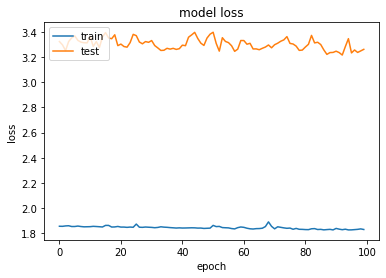

In [323]:
history2=apply_ANNL2(X_train,Y_train)

**Dropout**

In [312]:
premiere_couche3 = Dense(units=100, activation="relu", input_dim=20)
couche_cachee13 = Dense(units=200, activation="relu")
couche_cachee23 = Dense(units=50, activation="relu")
couche_sortie3 = Dense(units=1, activation="linear")

model3 = Sequential()
model3.add(premiere_couche3)
model3.add(Dropout(0.04))
model3.add(couche_cachee13)
model3.add(Dropout(0.04))
model3.add(couche_cachee23)
model3.add(Dropout(0.04))
model3.add(couche_sortie3)

In [313]:
model3.summary()
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.98)
opt = keras.optimizers.Adam(learning_rate=lr_schedule) ## définition d'un optimisze
model3.compile(optimizer=opt, loss="mse", metrics=["mse"])

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_125 (Dense)            (None, 100)               2100      
_________________________________________________________________
dropout_37 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_126 (Dense)            (None, 200)               20200     
_________________________________________________________________
dropout_38 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_127 (Dense)            (None, 50)                10050     
_________________________________________________________________
dropout_39 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_128 (Dense)            (None, 1)               

In [314]:
def apply_ANNDrop(X,Y):
    history3= model3.fit(X, Y, verbose=0, epochs=100, batch_size=40,validation_split=0.1)
    plt.plot(history3.history['loss'])
    plt.plot(history3.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return history3

**Résultats avec dropout**

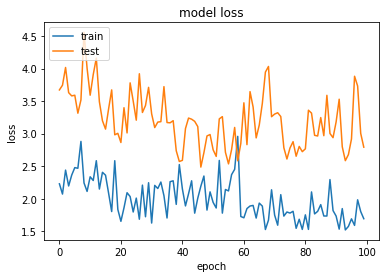

In [316]:
history3=apply_ANNDrop(X_train,Y_train)

**Comparaison**:

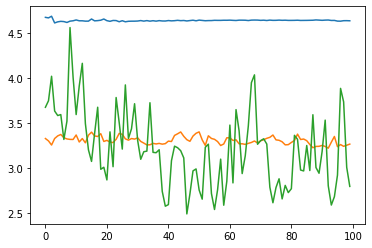

In [324]:
plt.plot(history.history['val_loss']) ## historique de la fonction cout du jeu de donnée "test"  ## historique de la fonction cout du jeu de donnée "train"
plt.plot(history2.history['val_loss']) ## historique de la fonction cout du jeu de donnée "test"## historique de la fonction cout du jeu de donnée "train"
plt.plot(history3.history['val_loss']) ## historique de la fonction cout du jeu de donnée "test"
plt.show()

## Conclusion

Lorsque le nombre de paramètres $m$ est supérieur ou se rapproche du nombre de points $n$ on risque le **sur-apprentissage**.

**Sur-apprentissage**: on colle trop à l'échantillon (cela peut revenir à apprendre le bruit ou les biais des échantillons). On généralise **moins bien** à des nouvelles données.

**Régularisation** : on ajoute des contraintes sur les coefficients.